##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# With adaptations and extensino by SOAI Zurich - Jeremy and Raphaela

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Compare a Convolutional Neural Network (CNN) To a Regular Fully Connected Neural Network

<img src="https://qph.fs.quoracdn.net/main-qimg-704ab7dc6b6ea6e7e919daab06a63537">

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training our model will take just a few lines of code.
We will then compare results to a fully connected model


### Import TensorFlow

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to our first layer.


In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of our model so far.

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Quiz Time
- What part of the CNN did we just assemble?
- Is this now a full CNN? Why, why not?
- How can you calculate the number of parameters in each layer?


### Add Dense layers on top
To complete our model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs and a softmax activation.

In [6]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's the complete architecture of our model.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

As you can see, our (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

**Params for layer conv2d**: (3x3x3+1)x32 = 896

filter size 3x3 plus 1 bias, 3 input feature maps channels = colors, 32 output feature maps


**Params for layer conv2d_1**: (3x3x32+1)x64 = 18496

filter size 3x3 plus 1 bias, 32 input feature maps from layer conv2d, 64 output feature maps


### Compile and train the CNN model

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 53s 34ms/step - loss: 1.5186 - accuracy: 0.4463 - val_loss: 1.2479 - val_accuracy: 0.5563
Epoch 2/10
1563/1563 [==============================] - 44s 28ms/step - loss: 1.1650 - accuracy: 0.5876 - val_loss: 1.1324 - val_accuracy: 0.6045
Epoch 3/10
1563/1563 [==============================] - 43s 27ms/step - loss: 1.0200 - accuracy: 0.6421 - val_loss: 0.9961 - val_accuracy: 0.6534
Epoch 4/10
1563/1563 [==============================] - 40s 26ms/step - loss: 0.9231 - accuracy: 0.6762 - val_loss: 0.9450 - val_accuracy: 0.6697
Epoch 5/10
1563/1563 [==============================] - 40s 26ms/step - loss: 0.8453 - accuracy: 0.7043 - val_loss: 0.9072 - val_accuracy: 0.6824
Epoch 6/10
1563/1563 [==============================] - 42s 27ms/step - loss: 0.7835 - accuracy: 0.7255 - val_loss: 0.8574 - val_accuracy: 0.7023
Epoch 7/10
1563/1563 [==============================] - 40s 25ms/step - loss: 0.7344 - accuracy: 0.7425 - val_loss: 0.8443 -

### Evaluate the CNN model

313/313 - 2s - loss: 0.8783 - accuracy: 0.7060


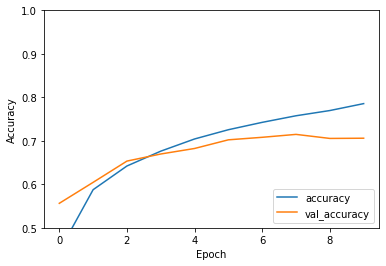

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [10]:
print(test_acc)

0.7059999704360962


In [11]:
del model

## Let's just use a regular neural net - why not?

Our simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, see an example using the Keras subclassing API and a `tf.GradientTape` [here](https://www.tensorflow.org/tutorials/quickstart/advanced).

Now let's compare this CNN model to a simple fully connected model.

https://github.com/YounesElhjouji/Fully-Connected-Cifar10-Classifier/blob/master/CIFAR10-Classifier.ipynb

In [12]:
# build sequential model by adding layers

#model_fc = tf.keras.Sequential()
#model_fc.add(tf.keras.layers.Dense(8, input_shape=(16,), activation="relu", name="layer1"))
#model_fc.add(tf.keras.layers.Dense(4, activation="relu", name="layer2"))

In [13]:
epochs = 30
nodes_per_layer = [1024,512,256,128,64]
layers = []
batch_size = 1
dropout_rate = 0.1
num_classes = 10

In [14]:
# alternative approach, use a for loop and use dropout after each layer
# use 

from tensorflow import keras
layers = []

layers.append(tf.keras.layers.Input(shape=(32, 32, 3,)))
layers.append(tf.keras.layers.Flatten())
for nodes in nodes_per_layer:
    layers.append(keras.layers.Dense(nodes, activation=tf.nn.relu)) # Using l2 regularization kernel_regularizer=tf.keras.regularizers.l2(l=0.0001)
    layers.append(keras.layers.Dropout(dropout_rate))

# layers.append(keras.layers.Dense(num_classes, activation='softmax'))
layers.append(keras.layers.Dense(num_classes))
layers.append(keras.layers.Softmax())
model_fc = keras.Sequential(layers)

In [15]:
model_fc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

### Compile and train the FC model

In [ ]:
# same code as above
# model_fc.compile(optimizer='adam', # tf.train.AdamOptimizer(0.001)
model_fc.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.8, beta_2=0.90),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

history_fc = model_fc.fit(train_images, train_labels, epochs=10, 
                          validation_data=(test_images, test_labels))
#hist = model.fit(x_train, y_train,epochs=10,batch_size=64,validation_data=(x_test,y_test),use_multiprocessing=True)

### Evaluate the regular FC model

In [ ]:
plt.plot(history_fc.history['accuracy'], label='accuracy')
plt.plot(history_fc.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_fc.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
print(test_acc)

In [ ]:
import numpy as np

In [ ]:
prediction = model_fc.predict(test_images[:1])
prediction = class_names[np.argmax(prediction)]

In [ ]:
actual = class_names[test_labels[0][0]]

In [ ]:
plt.imshow(test_images[0])
_ = plt.title(f"Prediction: {prediction}, Actual: {actual}")

### Quiz Time
- Why is it not a good idea to use a regular NN for image classification? What are the benefits of CNNs?


#### 1) Typical images are large: 100s of pixels. The 1st layer already has 10k weights!
In our example we've got 122k vs 3Mio parameters

Why is this bad? More parameters increase the capacity of the network to learn, hence we need a larger training set. We don't leverage the local correlation.

#### 2) Memory requirement to store so many weights may rule out certain hardware implementations.

#### 3) No built-invariance with respect to transformations and distortions in inputs.
We would need multiple units with similar weight patterns positioned at various locations in the input to detect distinctive features wherever they appear in the input. Many more combinations.
